In [1]:
# Imports y configuración de paths
import os, sys, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PROJ_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
DATA_PATH = os.path.join(PROJ_ROOT, 'data', 'processed', 'mortalidad')
BASE_OUT = os.path.join(PROJ_ROOT, 'modelos', 'outputs')
NOTEBOOK_NAME = os.path.splitext(os.path.basename(os.environ.get('NOTEBOOK_BASENAME', 'b_08_ml.ipynb')))[0]
OUT_DIR = os.path.join(BASE_OUT, 'output', NOTEBOOK_NAME)
os.makedirs(OUT_DIR, exist_ok=True)

print(f'Datos: {DATA_PATH}')
print(f'Salidas: {OUT_DIR}')

pd.set_option('display.width', 140)
pd.set_option('display.max_columns', 60)
sns.set_context('talk')
plt.rcParams['figure.figsize'] = (10,5)

Datos: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/data/processed/mortalidad
Salidas: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml


In [2]:
# Instalar/Importar TensorFlow si es necesario
try:
    import tensorflow as tf
    from tensorflow.keras import layers, models, callbacks, optimizers
    print('TensorFlow:', tf.__version__)
except Exception as e:
    import subprocess, sys as _sys
    print('Instalando TensorFlow ...')
    subprocess.check_call([_sys.executable, '-m', 'pip', 'install', '-q', 'tensorflow'])
    import tensorflow as tf
    from tensorflow.keras import layers, models, callbacks, optimizers
    print('TensorFlow:', tf.__version__)

TensorFlow: 2.17.0


In [3]:
# Estilo corporativo (viz.style)
for candidate in ('src', '../src', '../../src', '../../../src'):
    p = os.path.abspath(candidate)
    if os.path.isdir(p) and p not in sys.path:
        sys.path.append(p)
try:
    import importlib, viz.style as _vstyle
    importlib.reload(_vstyle)
except Exception:
    pass
from viz.style import apply_matplotlib_style, get_palette, get_sequential_cmap
apply_matplotlib_style(n_colors=7, base_font_size=11, seaborn_style='white', background='white', transparent=False)
print('Estilo aplicado.')

Estilo aplicado.


In [4]:
# Carga de datos y matriz edad×año (m y log(m))
EPS = 1e-12
file_long = os.path.join(DATA_PATH, 'tasas_mortalidad_gret_per.csv')
df_long = pd.read_csv(file_long).rename(columns={'ano':'year','gr_et':'age'})
df_long_m = df_long[['year','age','tasa_x100k']].copy()
df_long_m['m'] = (df_long_m['tasa_x100k'] / 1e5).clip(lower=EPS)
mat = df_long_m.pivot(index='age', columns='year', values='m').sort_index()
ages = mat.index.values.astype(int)
years = mat.columns.values.astype(int)
mat_log = np.log(mat.clip(lower=EPS))
print('Matriz m:', mat.shape, '| años', years.min(), '-', years.max(), '| edades', ages.min(), '-', ages.max())
mat.head()

Matriz m: (17, 45) | años 1979 - 2023 | edades 1 - 17


year,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
age,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.000049,0.000042,0.000044,0.000039,0.000028,0.000022,0.000024,0.000018,0.000015,0.000014,0.000011,0.000010,0.000009,0.000009,0.000008,0.000006,0.000006,0.000005,0.000004,0.000006,0.000006,0.000006,0.000005,8.499482e-06,0.000007,6.534167e-06,0.000006,7.710106e-06,0.000005,8.390200e-06,0.000006,0.000003,3.653421e-06,3.153650e-06,5.815563e-06,2.921598e-06,2.398540e-06,2.666065e-06,2.392366e-06,3.153282e-06,3.668709e-06,0.000002,3.129253e-06,4.469724e-06,0.000003
2,0.000012,0.000011,0.000013,0.000010,0.000006,0.000009,0.000009,0.000007,0.000007,0.000005,0.000003,0.000004,0.000004,0.000002,0.000004,0.000003,0.000002,0.000002,0.000002,0.000002,0.000001,0.000002,0.000003,2.798329e-06,0.000002,7.009429e-07,0.000003,1.657103e-06,0.000002,1.449898e-06,0.000002,0.000002,1.249956e-06,2.527166e-07,5.106775e-07,7.732517e-07,1.559143e-06,5.224731e-07,2.617115e-07,4.921904e-07,7.389123e-07,0.000001,4.932269e-07,2.482730e-07,0.000002
3,0.000009,0.000006,0.000010,0.000009,0.000006,0.000007,0.000004,0.000005,0.000003,0.000005,0.000002,0.000004,0.000003,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000003,0.000002,0.000003,7.387396e-07,0.000003,9.613654e-07,0.000002,9.458863e-07,0.000002,9.408289e-07,0.000002,0.000002,7.141590e-07,4.802836e-07,4.853084e-07,9.816835e-07,7.445327e-07,1.002307e-06,1.515173e-06,1.401163e-06,1.396822e-06,0.000001,9.338040e-07,1.178135e-06,0.000001
4,0.000015,0.000013,0.000017,0.000014,0.000012,0.000014,0.000015,0.000008,0.000011,0.000011,0.000008,0.000006,0.000008,0.000008,0.000007,0.000007,0.000006,0.000009,0.000005,0.000006,0.000006,0.000006,0.000006,7.621104e-06,0.000005,3.371316e-06,0.000003,4.305802e-06,0.000005,4.929344e-06,0.000003,0.000003,3.584486e-06,2.853929e-06,3.324185e-06,2.852953e-06,2.863328e-06,4.075270e-06,2.891899e-06,3.997186e-06,3.474033e-06,0.000004,4.770033e-06,5.670935e-06,0.000005
5,0.000034,0.000038,0.000032,0.000031,0.000027,0.000026,0.000019,0.000019,0.000023,0.000018,0.000015,0.000014,0.000014,0.000014,0.000013,0.000016,0.000013,0.000012,0.000011,0.000012,0.000012,0.000011,0.000012,1.439396e-05,0.000011,1.262662e-05,0.000008,8.655184e-06,0.000009,1.042390e-05,0.000010,0.000005,7.747502e-06,6.875696e-06,5.778954e-06,8.438986e-06,5.401696e-06,6.803984e-06,5.055585e-06,7.018536e-06,7.070214e-06,0.000007,1.016314e-05,1.279901e-05,0.000011


In [5]:
# Construcción de secuencias y split temporal
T = 10  # ventanas de historial
cut_year = 2018
idx_cut = int(np.where(years == cut_year)[0][0])
# Normalización (solo con train) en escala log
train_logs = mat_log.iloc[:, :idx_cut+1].values.reshape(-1)
mu, sigma = float(np.mean(train_logs)), float(np.std(train_logs) + 1e-8)

# Generar secuencias train para todas las edades
X_list, y_list, meta_age, meta_year = [], [], [], []
for age in ages:
    s = mat_log.loc[age].values
    for t in range(T, idx_cut+1):  # predice años <= 2018
        X_list.append((s[t-T:t] - mu)/sigma)
        y_list.append((s[t] - mu)/sigma)
        meta_age.append(int(age))
        meta_year.append(int(years[t]))
X_train = np.array(X_list, dtype=np.float32)[..., np.newaxis]  # (N,T,1)
y_train = np.array(y_list, dtype=np.float32)[..., np.newaxis]  # (N,1)
print('Secuencias train:', X_train.shape, y_train.shape)

Secuencias train: (510, 10, 1) (510, 1)


In [6]:
# Definición y entrenamiento del modelo CNN (Conv1D)
from tensorflow.keras import layers, models, callbacks, optimizers

model = models.Sequential([
    layers.Input(shape=(T, 1)),
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='causal'),
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='causal'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

opt = optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='mse')

es = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
hist = model.fit(X_train, y_train, validation_split=0.1, epochs=200, batch_size=32, verbose=0, callbacks=[es])

print('Entrenamiento completado. Épocas:', len(hist.history['loss']))

Entrenamiento completado. Épocas: 69


In [7]:
# Predicciones one-step para train (1979–2018)
yhat_train_scaled = model.predict(X_train, verbose=0).reshape(-1)
yhat_train_log = (yhat_train_scaled * sigma) + mu
ytrue_train_log = np.array([mat_log.loc[a, y] for a, y in zip(meta_age, meta_year)])
m_train_pred = np.exp(yhat_train_log)
m_train_obs = np.exp(ytrue_train_log)
train_df = pd.DataFrame({'age': meta_age, 'year': meta_year, 'm_obs': m_train_obs, 'm_pred': m_train_pred})
print('Predicciones train:', train_df.shape)

Predicciones train: (510, 4)


In [8]:
# Predicciones recursivas para validación (2019–2023)
val_years = years[idx_cut+1:]
Xv_meta_age, Xv_meta_year, yhat_val_log = [], [], []
for age in ages:
    s = mat_log.loc[age].values.copy()
    context = s[idx_cut+1-T:idx_cut+1].copy()  # últimos T hasta 2018
    for yy in val_years:
        xin = ((context - mu)/sigma).astype('float32').reshape(1, T, 1)
        y_scaled = float(model.predict(xin, verbose=0).reshape(-1)[0])
        y_log = y_scaled * sigma + mu
        yhat_val_log.append(y_log)
        Xv_meta_age.append(int(age)); Xv_meta_year.append(int(yy))
        context = np.concatenate([context[1:], [y_log]])

m_val_pred = np.exp(np.array(yhat_val_log))
m_val_obs = np.array([mat.loc[a, y] for a, y in zip(Xv_meta_age, Xv_meta_year)])
val_df = pd.DataFrame({'age': Xv_meta_age, 'year': Xv_meta_year, 'm_obs': m_val_obs, 'm_pred': m_val_pred})
print('Predicciones validación:', val_df.shape)

Predicciones validación: (85, 4)


In [9]:
# Métricas (m y log)
from sklearn.metrics import mean_squared_error, mean_absolute_error

def smape(y_true, y_pred, eps=1e-12):
    return 100 * np.mean(2*np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + eps))

def wape(y_true, y_pred, eps=1e-12):
    return 100 * (np.sum(np.abs(y_pred - y_true)) / (np.sum(np.abs(y_true)) + eps))

# Train
RMSE_train = float(np.sqrt(mean_squared_error(train_df['m_obs'], train_df['m_pred'])))
MAE_train = float(mean_absolute_error(train_df['m_obs'], train_df['m_pred']))
sMAPE_train = float(smape(train_df['m_obs'], train_df['m_pred']))
WAPE_train = float(wape(train_df['m_obs'], train_df['m_pred']))
RMSE_log_train = float(np.sqrt(mean_squared_error(np.log(train_df['m_obs'].clip(lower=EPS)), yhat_train_log)))

# Val
RMSE_val = float(np.sqrt(mean_squared_error(val_df['m_obs'], val_df['m_pred'])))
MAE_val = float(mean_absolute_error(val_df['m_obs'], val_df['m_pred']))
sMAPE_val = float(smape(val_df['m_obs'], val_df['m_pred']))
WAPE_val = float(wape(val_df['m_obs'], val_df['m_pred']))
RMSE_log_val = float(np.sqrt(mean_squared_error(np.log(val_df['m_obs'].clip(lower=EPS)), np.array(yhat_val_log))))

print('Métricas (escala original por persona):')
print(f'- Train | RMSE: {RMSE_train:.4e} | MAE: {MAE_train:.4e} | sMAPE: {sMAPE_train:.2f}% | WAPE: {WAPE_train:.2f}%')
print(f'- Val   | RMSE: {RMSE_val:.4e} | MAE: {MAE_val:.4e} | sMAPE: {sMAPE_val:.2f}% | WAPE: {WAPE_val:.2f}%')
print('Métricas (escala log):')
print(f'- Train | RMSE_log: {RMSE_log_train:.4e}')
print(f'- Val   | RMSE_log: {RMSE_log_val:.4e}')

Métricas (escala original por persona):
- Train | RMSE: 2.0758e-05 | MAE: 1.0723e-05 | sMAPE: 19.94% | WAPE: 15.23%
- Val   | RMSE: 1.4980e-05 | MAE: 9.8330e-06 | sMAPE: 43.64% | WAPE: 23.10%
Métricas (escala log):
- Train | RMSE_log: 2.7444e-01
- Val   | RMSE_log: 5.4516e-01


dtype pred full: [dtype('float64')]


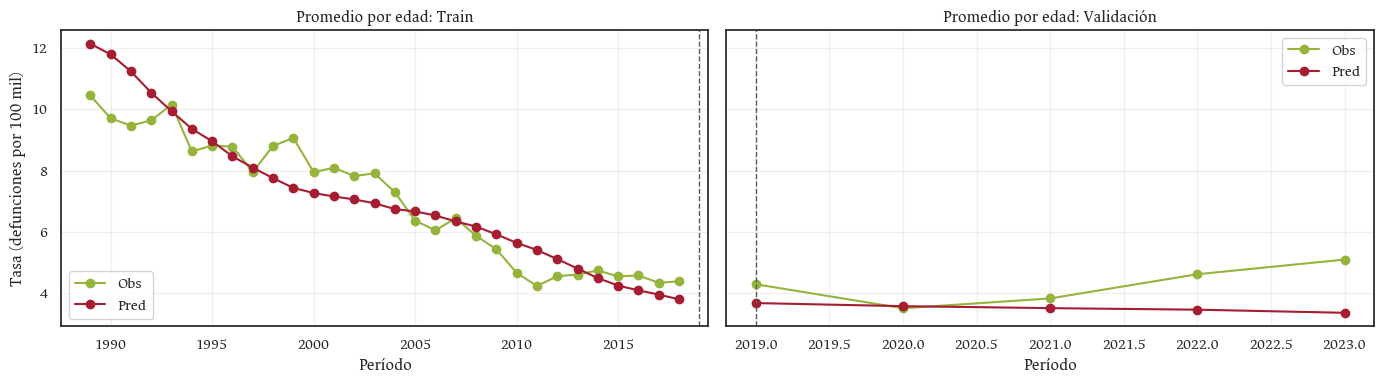

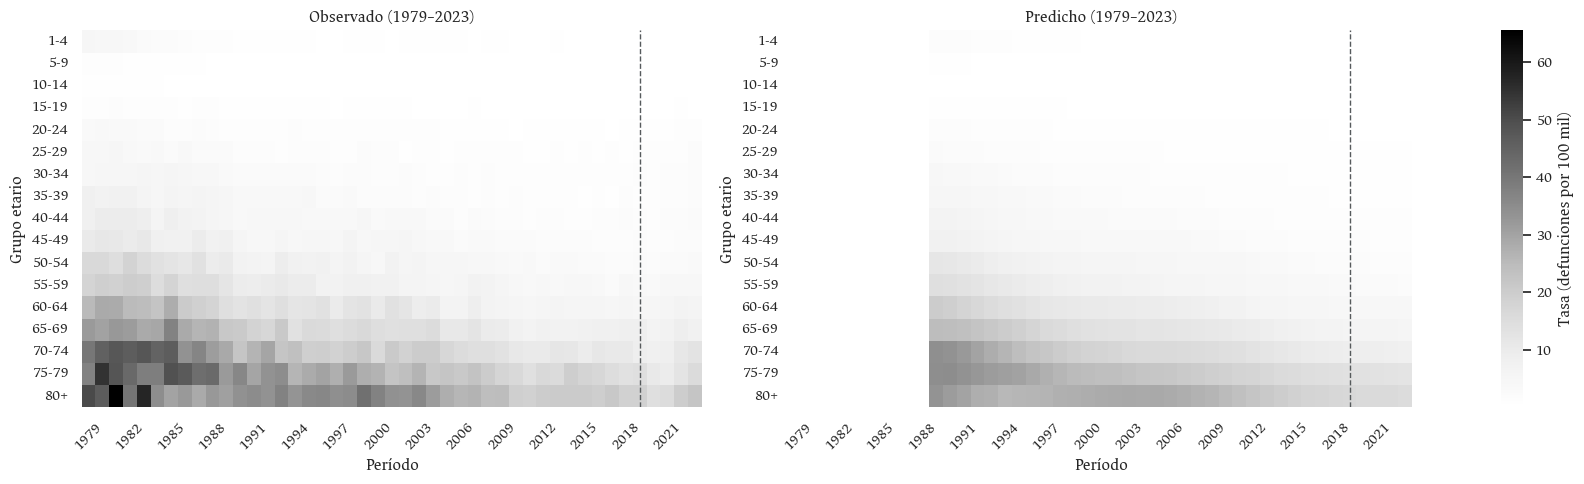

In [23]:
# Reconstrucción matrices y gráficos principales
from viz.style import get_palette, get_sequential_cmap
pal = get_palette(5)
color_obs, color_pred, color_vline = pal[0], pal[1], pal[4]

# Matrices predichas (m)
mat_train_pred = pd.pivot_table(train_df, index='age', columns='year', values='m_pred').reindex(index=ages, columns=years, fill_value=np.nan)
mat_val_pred = pd.pivot_table(val_df, index='age', columns='year', values='m_pred').reindex(index=ages, columns=years, fill_value=np.nan)
mat_obs_100k = mat * 1e5
mat_train_pred_100k = mat_train_pred * 1e5
mat_val_pred_100k = mat_val_pred * 1e5

# Averages por período
df_period_train = train_df.groupby('year')[['m_obs','m_pred']].mean().reset_index().rename(columns={'year':'period','m_obs':'obs','m_pred':'pred'})
df_period_val = val_df.groupby('year')[['m_obs','m_pred']].mean().reset_index().rename(columns={'year':'period','m_obs':'obs','m_pred':'pred'})

# Matriz completa predicha (100k) asegurando dtype float
mat_pred_full_100k = pd.DataFrame(np.nan, index=ages, columns=years, dtype=float)
train_periods = df_period_train['period'].values.astype(int)
val_periods = df_period_val['period'].values.astype(int)
mat_pred_full_100k.loc[:, train_periods] = mat_train_pred_100k.loc[:, train_periods].values.astype(float)
mat_pred_full_100k.loc[:, val_periods] = mat_val_pred_100k.loc[:, val_periods].values.astype(float)
print('dtype pred full:', mat_pred_full_100k.dtypes.unique())

# Líneas promedio por período (100k)
fig, ax = plt.subplots(1,2, figsize=(14,4), sharey=True)
ax[0].plot(df_period_train['period'], df_period_train['obs']*1e5, label='Obs', marker='o', color=color_obs)
ax[0].plot(df_period_train['period'], df_period_train['pred']*1e5, label='Pred', marker='o', color=color_pred)
ax[0].set_title('Promedio por edad: Train'); ax[0].set_xlabel('Período'); ax[0].set_ylabel('Tasa (defunciones por 100 mil)'); ax[0].grid(alpha=0.3); ax[0].legend(); ax[0].axvline(2019, color=color_vline, ls='--', lw=1)
ax[1].plot(df_period_val['period'], df_period_val['obs']*1e5, label='Obs', marker='o', color=color_obs)
ax[1].plot(df_period_val['period'], df_period_val['pred']*1e5, label='Pred', marker='o', color=color_pred)
ax[1].set_title('Promedio por edad: Validación'); ax[1].set_xlabel('Período'); ax[1].grid(alpha=0.3); ax[1].legend(); ax[1].axvline(2019, color=color_vline, ls='--', lw=1)
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,'cnn_lineas_obs_vs_pred_100k.png'), dpi=180); plt.show()

# Heatmaps Obs vs Pred
vmin = float(min(mat_obs_100k.values.min(), mat_pred_full_100k.values.min()))
vmax = float(max(mat_obs_100k.values.max(), mat_pred_full_100k.values.max()))
# cmap_seq = get_sequential_cmap(index=0)
cmap_seq = 'Greys'
ages_sorted = np.sort(ages)
# Etiquetas de grupos etarios: 1: 1-4, 2: 5-9, ..., 17: 80+
zero_based = int(ages_sorted.min()) == 0
max_code = int(ages_sorted.max() + 1) if zero_based else int(ages_sorted.max())
def _age_label_from_code(code):
    g = int(code) + 1 if zero_based else int(code)
    if g == max_code:
        return '80+'
    if g == 1:
        return '1-4'
    start = 5 * (g - 1)
    end = start + 4
    return f'{start}-{end}'
age_labels = [_age_label_from_code(a) for a in ages_sorted]

fig = plt.figure(figsize=(16,5))
gs = fig.add_gridspec(1,3, width_ratios=[1,1,0.035])
ax0 = fig.add_subplot(gs[0,0]); ax1 = fig.add_subplot(gs[0,1], sharey=ax0); cax = fig.add_subplot(gs[0,2])
sns.heatmap(mat_obs_100k, ax=ax0, cmap=cmap_seq, vmin=vmin, vmax=vmax, cbar=False)
ax0.set_title('Observado (defunciones por 100 mil habs.)'); ax0.set_xlabel('Período'); ax0.set_ylabel('Grupo etario')
sns.heatmap(mat_pred_full_100k, ax=ax1, cmap=cmap_seq, vmin=vmin, vmax=vmax, cbar=True, cbar_ax=cax)
ax1.set_title('Pronóstico (defunciones por 100 mil habs.)'); ax1.set_xlabel('Período'); ax1.set_ylabel('Grupo etario')

tick_years = np.arange(1979, 2022, 3)
period_list = list(years)
pos_ticks = [period_list.index(y)+0.5 for y in tick_years if y in period_list]
lab_ticks = [str(y) for y in tick_years if y in period_list]
for a in (ax0, ax1):
    a.set_xticks(pos_ticks); a.set_xticklabels(lab_ticks, rotation=45)
idx_2019 = np.where(years == 2019)[0]
if len(idx_2019):
    xline = idx_2019[0]+0.5
    ax0.axvline(xline, color=color_vline, ls='--', lw=1)
    ax1.axvline(xline, color=color_vline, ls='--', lw=1)

# Aplicar etiquetas de edad en eje Y
for a in (ax0, ax1):
    a.set_yticklabels(age_labels, rotation=0)

cax.set_ylabel('Tasa (defunciones por 100 mil)')
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,'cnn_matrices_obs_pred_1979_2023_100k.png'), dpi=180); plt.show()

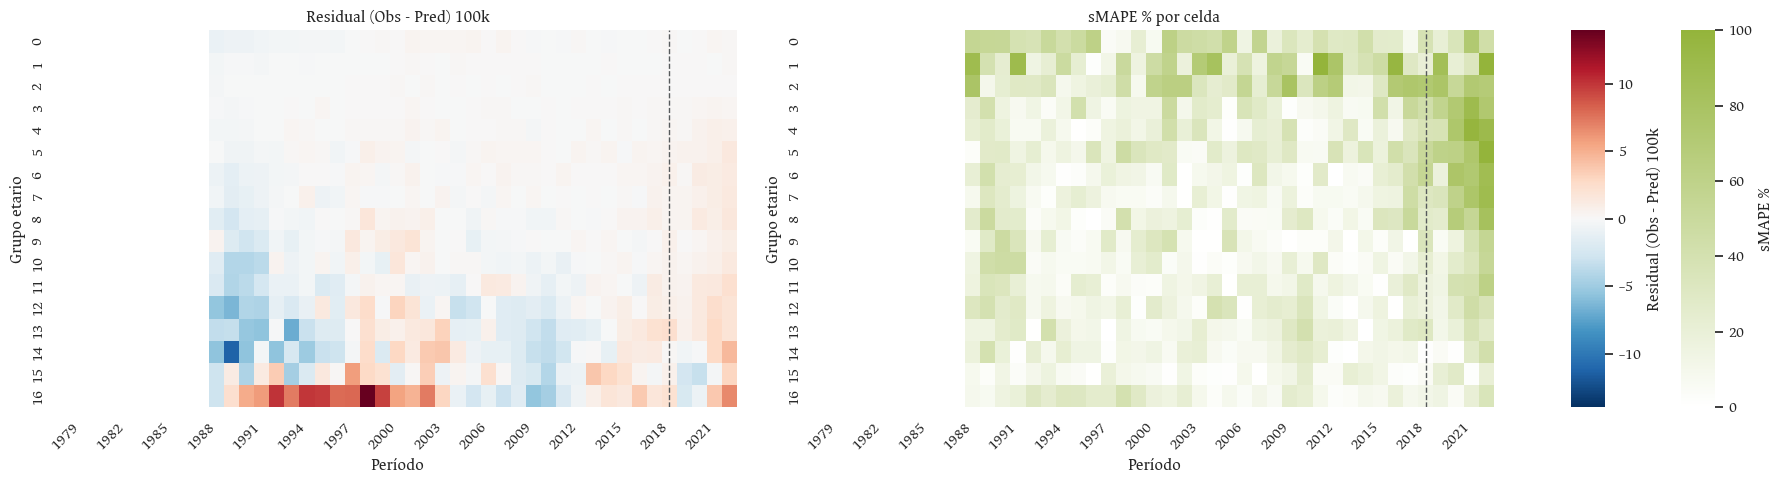

In [11]:
# Heatmaps residuales y sMAPE por celda
EPS_CELL = 1e-12
resid_100k = mat_obs_100k.values - mat_pred_full_100k.values
smape_cell = (2 * np.abs(mat_pred_full_100k.values - mat_obs_100k.values) / (np.abs(mat_pred_full_100k.values) + np.abs(mat_obs_100k.values) + EPS_CELL))*100
vmax_res = np.nanmax(np.abs(resid_100k)); vmin_res = -vmax_res
vmin_sm, vmax_sm = 0, min(100, np.nanmax(smape_cell))

# Etiquetas de grupos etarios: 1: 1-4, 2: 5-9, ..., 17: 80+
ages_sorted = np.sort(ages)
zero_based = int(ages_sorted.min()) == 0
max_code = int(ages_sorted.max() + 1) if zero_based else int(ages_sorted.max())
def _age_label_from_code(code):
    g = int(code) + 1 if zero_based else int(code)
    if g == max_code:
        return '80+'
    if g == 1:
        return '1-4'
    start = 5 * (g - 1)
    end = start + 4
    return f'{start}-{end}'
age_labels = [_age_label_from_code(a) for a in ages_sorted]

cmap_seq = get_sequential_cmap(index=0)
fig = plt.figure(figsize=(18,5))
gs = fig.add_gridspec(1,4, width_ratios=[1,1,0.05,0.05])
ax_r = fig.add_subplot(gs[0,0]); ax_s = fig.add_subplot(gs[0,1], sharey=ax_r); cax_r = fig.add_subplot(gs[0,2]); cax_s = fig.add_subplot(gs[0,3])

sns.heatmap(resid_100k, ax=ax_r, cmap='RdBu_r', vmin=vmin_res, vmax=vmax_res, cbar=True, cbar_ax=cax_r)
ax_r.set_title('Residual (Obs - Pred) 100k'); ax_r.set_xlabel('Período'); ax_r.set_ylabel('Grupo etario')

sns.heatmap(smape_cell, ax=ax_s, cmap=cmap_seq, vmin=vmin_sm, vmax=vmax_sm, cbar=True, cbar_ax=cax_s)
ax_s.set_title('sMAPE % por celda'); ax_s.set_xlabel('Período'); ax_s.set_ylabel('Grupo etario')

# Aplicar etiquetas de edad en eje Y
for a in (ax_r, ax_s):
    a.set_yticklabels(age_labels, rotation=0)

tick_years = np.arange(1979, 2022, 3); period_list = list(years)
pos_ticks = [period_list.index(y)+0.5 for y in tick_years if y in period_list]
lab_ticks = [str(y) for y in tick_years if y in period_list]
for a in (ax_r, ax_s):
    a.set_xticks(pos_ticks); a.set_xticklabels(lab_ticks, rotation=45)
idx_2019 = np.where(years == 2019)[0]
if len(idx_2019):
    xline = idx_2019[0]+0.5
    for a in (ax_r, ax_s): a.axvline(xline, color=color_vline, ls='--', lw=1)

cax_r.set_ylabel('Residual (Obs - Pred) 100k')
cax_s.set_ylabel('sMAPE %')
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,'cnn_heatmaps_residual_smape_100k.png'), dpi=180); plt.show()

In [12]:
# Exportar matrices y formato long
mat_pred_full_m = mat_pred_full_100k / 1e5
mat_pred_full_m.index.name = 'gr_et'
mat_pred_full_100k.index.name = 'gr_et'
mat_pred_full_m.reset_index().to_csv(os.path.join(OUT_DIR,'cnn_matriz_pred_m.csv'), index=False)
mat_pred_full_100k.reset_index().to_csv(os.path.join(OUT_DIR,'cnn_matriz_pred_tasa_x100k.csv'), index=False)

# Formato long con errores (100k)
EPS_ERR = 1e-12
train_long = train_df.copy(); val_long = val_df.copy()
for d in (train_long, val_long):
    d['obs_tasa_x100k'] = d['m_obs'] * 1e5
    d['pred_tasa_x100k'] = d['m_pred'] * 1e5
    d['abs_error_100k'] = (d['pred_tasa_x100k'] - d['obs_tasa_x100k']).abs()
    d['rel_abs_error'] = d['abs_error_100k'] / (d['obs_tasa_x100k'].abs() + EPS_ERR)
train_long['dataset'] = 'train'; val_long['dataset'] = 'valid'
cols_out = ['dataset','year','age','obs_tasa_x100k','pred_tasa_x100k','abs_error_100k','rel_abs_error']
pred_long = pd.concat([train_long[cols_out], val_long[cols_out]], ignore_index=True).sort_values(['dataset','year','age']).reset_index(drop=True)
long_path = os.path.join(OUT_DIR,'cnn_predicciones_long_100k.csv')
pred_long.to_csv(long_path, index=False)
print('Exportaciones guardadas en:', OUT_DIR)
print('Long shape:', pred_long.shape)
pred_long.head()

Exportaciones guardadas en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml
Long shape: (595, 7)


,dataset,year,age,obs_tasa_x100k,pred_tasa_x100k,abs_error_100k,rel_abs_error
0,train,1989,1,1.143999,2.019617,0.875618,0.765402
1,train,1989,2,0.261641,0.686055,0.424414,1.622124
2,train,1989,3,0.202635,0.461940,0.259305,1.279670
3,train,1989,4,0.764219,0.981605,0.217387,0.284456
4,train,1989,5,1.505478,1.882443,0.376965,0.250396


# Sección: Búsqueda en grilla de hiperparámetros
## Objetivo
Realizar el mismo ajuste del modelo variando hiperparámetros y seleccionar el mejor según métrica de validación.

In [13]:
# Búsqueda en grilla usando la misma CNN y validación recursiva
import itertools
import numpy as np
import pandas as pd
from copy import deepcopy
from tensorflow.keras import layers, models, callbacks, optimizers

# Grilla de hiperparámetros
param_grid = {
    "conv_layers": [2, 3],            
    "filters": [16, 32, 64],          
    "kernel_size": [3, 5],            
    "dense_units": [16, 32],          
    "learning_rate": [1e-3, 5e-4],    
    "batch_size": [32, 64],           
    "epochs": [150, 250],             
    "spatial_dropout": [0.0, 0.1, 0.2],
    "dense_dropout": [0.0, 0.3, 0.5]
}

es_cb = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)


def build_cnn(conv_layers=2, filters=32, kernel_size=3, dense_units=16, learning_rate=1e-3,
    spatial_dropout=0.0, dense_dropout=0.0):
    model = models.Sequential()
    model.add(layers.Input(shape=(T, 1)))
    for _ in range(conv_layers):
        model.add(
            layers.Conv1D(
                filters=filters,
                kernel_size=kernel_size,
                activation='relu',
                padding='causal'))
        if spatial_dropout > 0.0:
            model.add(layers.SpatialDropout1D(spatial_dropout))
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dense(dense_units, activation='relu'))
    if dense_dropout > 0.0:
        model.add(layers.Dropout(dense_dropout))
    model.add(layers.Dense(1))
    opt = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mse')
    return model


def compute_metrics(y_true, y_pred):
    eps = EPS if 'EPS' in globals() else 1e-12
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    mae = float(np.mean(np.abs(y_true - y_pred)))
    wape = float(100 * (np.sum(np.abs(y_pred - y_true)) / (np.sum(np.abs(y_true)) + eps)))
    smape = float(100 * np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps)))
    mape = float(100 * np.mean(np.abs((y_true - y_pred) / (y_true + eps))))
    return {"RMSE": rmse, "MAE": mae, "WAPE": wape, "sMAPE": smape, "MAPE": mape, "MSE": rmse**2}


def predict_recursive(model):
    # Reproduce la lógica de la celda de validación (2019–2023)
    val_years_local = years[idx_cut+1:]
    Xv_meta_age_local, Xv_meta_year_local, yhat_val_log_local = [], [], []
    for age in ages:
        s = mat_log.loc[age].values.copy()
        context = s[idx_cut+1-T:idx_cut+1].copy()
        for yy in val_years_local:
            xin = ((context - mu)/sigma).astype('float32').reshape(1, T, 1)
            y_scaled = float(model.predict(xin, verbose=0).reshape(-1)[0])
            y_log = y_scaled * sigma + mu
            yhat_val_log_local.append(y_log)
            Xv_meta_age_local.append(int(age)); Xv_meta_year_local.append(int(yy))
            context = np.concatenate([context[1:], [y_log]])
    m_val_pred_local = np.exp(np.array(yhat_val_log_local))
    m_val_obs_local = np.array([mat.loc[a, y] for a, y in zip(Xv_meta_age_local, Xv_meta_year_local)])
    return m_val_obs_local, m_val_pred_local


results = []
best = {"params": None, "metrics": None, "history": None}

In [14]:
# Ejecutar grilla
for values in itertools.product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), values))
    try:
        spatial_dropout = 0.0 if params["filters"] <= 16 else params["spatial_dropout"]
        model_g = build_cnn(
            conv_layers=params["conv_layers"],
            filters=params["filters"],
            kernel_size=params["kernel_size"],
            dense_units=params["dense_units"],
            learning_rate=params["learning_rate"],
            spatial_dropout=spatial_dropout,
            dense_dropout=params["dense_dropout"],
        )
        hist_g = model_g.fit(
            X_train, y_train,
            validation_split=0.1,
            epochs=params["epochs"],
            batch_size=params["batch_size"],
            verbose=0,
            callbacks=[es_cb],
            shuffle=False,
        )
        # Validación recursiva sobre el mismo set que arriba
        m_val_obs_g, m_val_pred_g = predict_recursive(model_g)
        metrics = compute_metrics(m_val_obs_g, m_val_pred_g)
        row = deepcopy(params); row.update(metrics)
        results.append(row)
        if (best["metrics"] is None) or (metrics["sMAPE"] < best["metrics"]["sMAPE"]):
            best["params"] = params
            best["metrics"] = metrics
            best["history"] = hist_g.history
    except Exception as e:
        row = deepcopy(params)
        row.update({"error": str(e)})
        results.append(row)

In [15]:
# Mostrar resultados
df_results = pd.DataFrame(results)
display(df_results.sort_values(['sMAPE','RMSE'], ascending=[True, True]).head(10))
print("Mejor configuración:")
print(best["params"]) 
print("Métricas de validación (mejor):", best["metrics"])

,conv_layers,filters,kernel_size,dense_units,learning_rate,batch_size,epochs,spatial_dropout,dense_dropout,RMSE,MAE,WAPE,sMAPE,MAPE,MSE
0,2,16,3,16,0.001,32,150,0.0,0.0,0.000014,0.000009,20.650314,31.417291,27.143076,2.037337e-10
384,2,32,3,32,0.001,64,150,0.2,0.0,0.000013,0.000009,19.975244,36.157887,30.608006,1.741827e-10
369,2,32,3,32,0.001,32,250,0.0,0.0,0.000014,0.000010,22.544130,42.914619,33.820074,2.082911e-10
734,2,64,5,16,0.001,32,250,0.1,0.5,0.000045,0.000023,54.354165,44.491843,38.468817,2.069581e-09
798,2,64,5,32,0.001,32,150,0.2,0.0,0.000048,0.000025,58.303131,48.139729,39.826536,2.337161e-09
1657,3,64,5,32,0.001,32,150,0.0,0.3,0.000049,0.000025,58.715737,48.457580,39.256449,2.378199e-09
793,2,64,5,32,0.001,32,150,0.0,0.3,0.000048,0.000025,58.028039,48.543122,42.760122,2.347244e-09
803,2,64,5,32,0.001,32,250,0.0,0.5,0.000047,0.000024,56.701123,48.594954,45.977923,2.255641e-09
725,2,64,5,16,0.001,32,150,0.1,0.5,0.000047,0.000024,56.312085,48.698987,47.445624,2.233297e-09
795,2,64,5,32,0.001,32,150,0.1,0.0,0.000046,0.000024,55.233078,48.798421,49.550550,2.137575e-09


Mejor configuración:
{'conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'dense_units': 16, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'spatial_dropout': 0.0, 'dense_dropout': 0.0}
Métricas de validación (mejor): {'RMSE': 1.4273530429645186e-05, 'MAE': 8.788671604146255e-06, 'WAPE': 20.650314247124214, 'sMAPE': 31.417291254895442, 'MAPE': 27.143076350415125, 'MSE': 2.0373367092600708e-10}


In [16]:
# Mejor modelo: reentrenar, predecir y métricas (train y validación)
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras import callbacks

assert 'best' in globals() and best.get('params') is not None, "No se encontraron hiperparámetros 'best'. Ejecuta la celda de grilla primero."

# Reconstruir y entrenar el mejor modelo
best_params = best['params']
best_model = build_cnn(
    conv_layers=best_params['conv_layers'],
    filters=best_params['filters'],
    kernel_size=best_params['kernel_size'],
    dense_units=best_params['dense_units'],
    learning_rate=best_params['learning_rate']
)
es2 = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
hist_best = best_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=0,
    callbacks=[es2]
)

# Predicciones one-step para TRAIN con mejor modelo
yhat_train_scaled_best = best_model.predict(X_train, verbose=0).reshape(-1)
yhat_train_log_best = (yhat_train_scaled_best * sigma) + mu
# Verdaderos (log) para TRAIN usando meta_age/meta_year
ytrue_train_log_best = np.array([mat_log.loc[a, y] for a, y in zip(meta_age, meta_year)])
# A escala original (m)
m_train_pred_best = np.exp(yhat_train_log_best)
m_train_obs_best = np.exp(ytrue_train_log_best)

# DataFrame de TRAIN (mejor)
train_df_best = pd.DataFrame({'age': meta_age, 'year': meta_year, 'm_obs': m_train_obs_best, 'm_pred': m_train_pred_best})

# Predicciones recursivas VALIDACIÓN con mejor modelo (2019–2023)
def _predict_recursive_with(model):
    val_years_local = years[idx_cut+1:]
    Xv_meta_age_local, Xv_meta_year_local, yhat_val_log_local = [], [], []
    for age in ages:
        s = mat_log.loc[age].values.copy()
        context = s[idx_cut+1-T:idx_cut+1].copy()
        for yy in val_years_local:
            xin = ((context - mu)/sigma).astype('float32').reshape(1, T, 1)
            y_scaled = float(model.predict(xin, verbose=0).reshape(-1)[0])
            y_log = y_scaled * sigma + mu
            yhat_val_log_local.append(y_log)
            Xv_meta_age_local.append(int(age)); Xv_meta_year_local.append(int(yy))
            context = np.concatenate([context[1:], [y_log]])
    m_val_pred_local = np.exp(np.array(yhat_val_log_local))
    m_val_obs_local = np.array([mat.loc[a, y] for a, y in zip(Xv_meta_age_local, Xv_meta_year_local)])
    return Xv_meta_age_local, Xv_meta_year_local, m_val_obs_local, m_val_pred_local, np.array(yhat_val_log_local)

Xv_age_b, Xv_year_b, m_val_obs_b, m_val_pred_b, yhat_val_log_b = _predict_recursive_with(best_model)
val_df_best = pd.DataFrame({'age': Xv_age_b, 'year': Xv_year_b, 'm_obs': m_val_obs_b, 'm_pred': m_val_pred_b})

# Métricas
EPS_LOCAL = EPS if 'EPS' in globals() else 1e-12

def _smape(y_true, y_pred, eps=1e-12):
    return 100 * np.mean(2*np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + eps))

def _wape(y_true, y_pred, eps=1e-12):
    return 100 * (np.sum(np.abs(y_pred - y_true)) / (np.sum(np.abs(y_true)) + eps))

# Train (mejor)
RMSE_train_best = float(np.sqrt(mean_squared_error(m_train_obs_best, m_train_pred_best)))
MAE_train_best = float(mean_absolute_error(m_train_obs_best, m_train_pred_best))
sMAPE_train_best = float(_smape(m_train_obs_best, m_train_pred_best))
WAPE_train_best = float(_wape(m_train_obs_best, m_train_pred_best))
RMSE_log_train_best = float(np.sqrt(mean_squared_error(np.log(np.clip(m_train_obs_best, EPS_LOCAL, None)), yhat_train_log_best)))
MSE_train_best = RMSE_train_best**2
MSE_log_train_best = RMSE_log_train_best**2
MAPE_train_best = float(100 * np.mean(np.abs((m_train_obs_best - m_train_pred_best) / (m_train_obs_best + EPS_LOCAL))))


# Val (mejor)
RMSE_val_best = float(np.sqrt(mean_squared_error(val_df_best['m_obs'], val_df_best['m_pred'])))
MAE_val_best = float(mean_absolute_error(val_df_best['m_obs'], val_df_best['m_pred']))
sMAPE_val_best = float(_smape(val_df_best['m_obs'], val_df_best['m_pred']))
WAPE_val_best = float(_wape(val_df_best['m_obs'], val_df_best['m_pred']))
RMSE_log_val_best = float(np.sqrt(mean_squared_error(np.log(np.clip(val_df_best['m_obs'].values, EPS_LOCAL, None)), yhat_val_log_b)))
MSE_val_best = RMSE_val_best**2
MAPE_val_best = float(100 * np.mean(np.abs((val_df_best['m_obs'].values - val_df_best['m_pred'].values) / (val_df_best['m_obs'].values + EPS_LOCAL))))

print('Métricas MEJOR MODELO (escala original por persona):')
print(f'- Train | RMSE: {RMSE_train_best:.4e} | MAE: {MAE_train_best:.4e} | sMAPE: {sMAPE_train_best:.2f}% | WAPE: {WAPE_train_best:.2f}% | MSE: {MSE_train_best:.4e} | MAPE: {MAPE_train_best:.2f}%')
print(f'- Val   | RMSE: {RMSE_val_best:.4e} | MAE: {MAE_val_best:.4e} | sMAPE: {sMAPE_val_best:.2f}% | WAPE: {WAPE_val_best:.2f}% | | MSE: {MSE_val_best:.4e} | MAPE: {MAPE_val_best:.2f}%')
print('Métricas MEJOR MODELO (escala log):')
print(f'- Train | RMSE_log: {RMSE_log_train_best:.4e} | MSE_log: {MSE_log_train_best:.4e}')
print(f'- Val   | RMSE_log: {RMSE_log_val_best:.4e}')

Métricas MEJOR MODELO (escala original por persona):
- Train | RMSE: 2.0136e-05 | MAE: 1.0352e-05 | sMAPE: 19.68% | WAPE: 14.70% | MSE: 4.0545e-10 | MAPE: 21.53%
- Val   | RMSE: 1.5359e-05 | MAE: 9.8990e-06 | sMAPE: 42.91% | WAPE: 23.26% | | MSE: 2.3590e-10 | MAPE: 33.81%
Métricas MEJOR MODELO (escala log):
- Train | RMSE_log: 2.7283e-01 | MSE_log: 7.4437e-02
- Val   | RMSE_log: 5.3246e-01


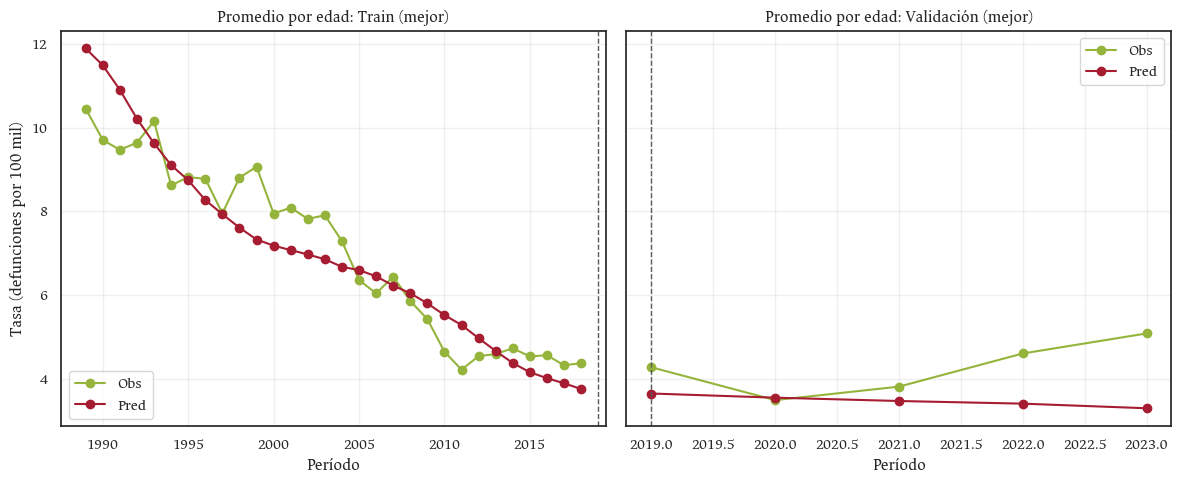

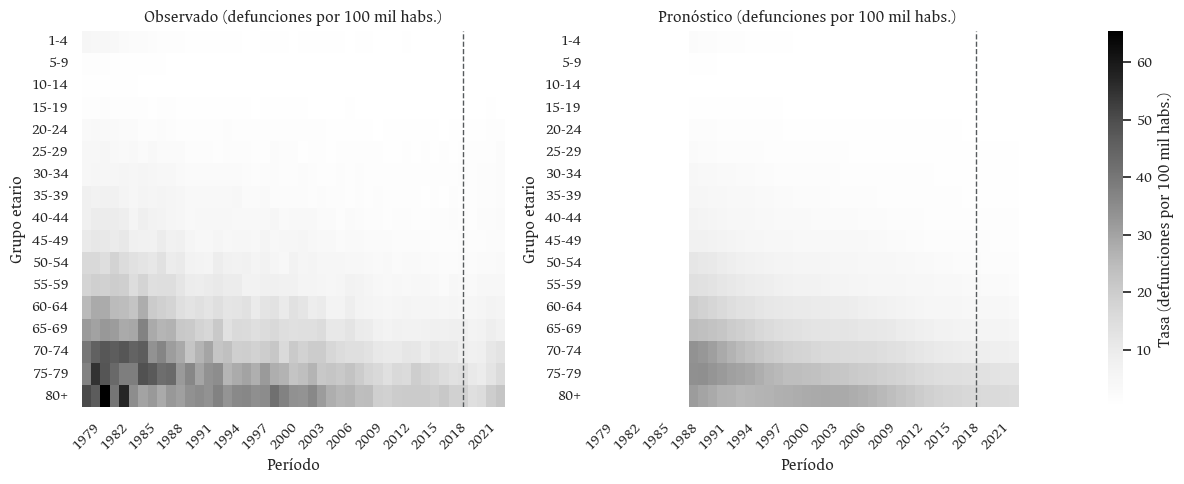

In [32]:
# Mejor modelo: matrices y heatmaps (Obs vs Pred)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from viz.style import get_palette, get_sequential_cmap

# Asegurar disponibilidad de dataframes del mejor modelo
assert 'train_df_best' in globals() and 'val_df_best' in globals(), "Faltan predicciones del mejor modelo. Ejecuta la celda anterior."

pal = get_palette(5)
color_obs, color_pred, color_vline = pal[0], pal[1], pal[4]

# Matrices predichas (m)
mat_train_pred_best = pd.pivot_table(train_df_best, index='age', columns='year', values='m_pred').reindex(index=ages, columns=years, fill_value=np.nan)
mat_val_pred_best = pd.pivot_table(val_df_best, index='age', columns='year', values='m_pred').reindex(index=ages, columns=years, fill_value=np.nan)
mat_obs_100k = mat * 1e5
mat_train_pred_100k_best = mat_train_pred_best * 1e5
mat_val_pred_100k_best = mat_val_pred_best * 1e5

# Averages por período
_df_period_train_b = train_df_best.groupby('year')[['m_obs','m_pred']].mean().reset_index().rename(columns={'year':'period','m_obs':'obs','m_pred':'pred'})
_df_period_val_b = val_df_best.groupby('year')[['m_obs','m_pred']].mean().reset_index().rename(columns={'year':'period','m_obs':'obs','m_pred':'pred'})

# Matriz completa predicha (100k)
mat_pred_full_100k_best = pd.DataFrame(np.nan, index=ages, columns=years, dtype=float)
train_periods_b = _df_period_train_b['period'].values.astype(int)
val_periods_b = _df_period_val_b['period'].values.astype(int)
mat_pred_full_100k_best.loc[:, train_periods_b] = mat_train_pred_100k_best.loc[:, train_periods_b].values.astype(float)
mat_pred_full_100k_best.loc[:, val_periods_b] = mat_val_pred_100k_best.loc[:, val_periods_b].values.astype(float)

# Líneas promedio por período (100k)
fig, ax = plt.subplots(1,2, figsize=(12,5), sharey=True)
ax[0].plot(_df_period_train_b['period'], _df_period_train_b['obs']*1e5, label='Obs', marker='o', color=color_obs)
ax[0].plot(_df_period_train_b['period'], _df_period_train_b['pred']*1e5, label='Pred', marker='o', color=color_pred)
ax[0].set_title('Promedio por edad: Train (mejor)'); ax[0].set_xlabel('Período'); ax[0].set_ylabel('Tasa (defunciones por 100 mil)'); ax[0].grid(alpha=0.3); ax[0].legend(); ax[0].axvline(2019, color=color_vline, ls='--', lw=1)
ax[1].plot(_df_period_val_b['period'], _df_period_val_b['obs']*1e5, label='Obs', marker='o', color=color_obs)
ax[1].plot(_df_period_val_b['period'], _df_period_val_b['pred']*1e5, label='Pred', marker='o', color=color_pred)
ax[1].set_title('Promedio por edad: Validación (mejor)'); ax[1].set_xlabel('Período'); ax[1].grid(alpha=0.3); ax[1].legend(); ax[1].axvline(2019, color=color_vline, ls='--', lw=1)
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,'cnn_best_lineas_obs_vs_pred_100k.png'), dpi=180); plt.show()

# Heatmaps Obs vs Pred (best)
vmin_b = float(min(mat_obs_100k.values.min(), mat_pred_full_100k_best.values.min()))
vmax_b = float(max(mat_obs_100k.values.max(), mat_pred_full_100k_best.values.max()))
# cmap_seq = get_sequential_cmap(index=0)
cmap_seq = 'Greys'
ages_sorted = np.sort(ages)
# Etiquetas de grupos etarios: 1: 1-4, 2: 5-9, ..., 17: 80+
zero_based = int(ages_sorted.min()) == 0
max_code = int(ages_sorted.max() + 1) if zero_based else int(ages_sorted.max())
def _age_label_from_code(code):
    g = int(code) + 1 if zero_based else int(code)
    if g == max_code:
        return '80+'
    if g == 1:
        return '1-4'
    start = 5 * (g - 1)
    end = start + 4
    return f'{start}-{end}'
age_labels = [_age_label_from_code(a) for a in ages_sorted]

fig = plt.figure(figsize=(12,5))

gs = fig.add_gridspec(1,3, width_ratios=[1,1,0.035])
ax0 = fig.add_subplot(gs[0,0]); ax1 = fig.add_subplot(gs[0,1], sharey=ax0); cax = fig.add_subplot(gs[0,2])
sns.heatmap(mat_obs_100k, ax=ax0, cmap=cmap_seq, vmin=vmin_b, vmax=vmax_b, cbar=False)
ax0.set_title('Observado (defunciones por 100 mil habs.)'); ax0.set_xlabel('Período'); ax0.set_ylabel('Grupo etario')
sns.heatmap(mat_pred_full_100k_best, ax=ax1, cmap=cmap_seq, vmin=vmin_b, vmax=vmax_b, cbar=True, cbar_ax=cax)
ax1.set_title('Pronóstico (defunciones por 100 mil habs.)'); ax1.set_xlabel('Período'); ax1.set_ylabel('Grupo etario')

tick_years = np.arange(1979, 2022, 3)
period_list = list(years)
pos_ticks = [period_list.index(y)+0.5 for y in tick_years if y in period_list]
lab_ticks = [str(y) for y in tick_years if y in period_list]
for a in (ax0, ax1):
    a.set_xticks(pos_ticks); a.set_xticklabels(lab_ticks, rotation=45)
idx_2019 = np.where(years == 2019)[0]
if len(idx_2019):
    xline = idx_2019[0]+0.5
    ax0.axvline(xline, color=color_vline, ls='--', lw=1)
    ax1.axvline(xline, color=color_vline, ls='--', lw=1)

# Aplicar etiquetas de edad en eje Y
for a in (ax0, ax1):
    a.set_yticklabels(age_labels, rotation=0)

cax.set_ylabel('Tasa (defunciones por 100 mil habs.)')
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,'cnn_best_matrices_obs_pred_1979_2023_100k.png'), dpi=180); plt.show()

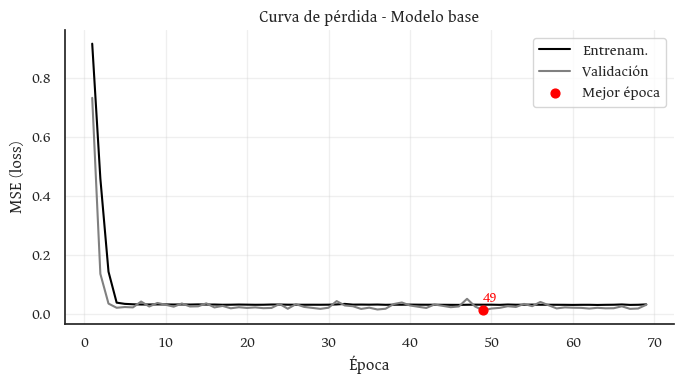

Figura guardada en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml/cnn_loss_base.png


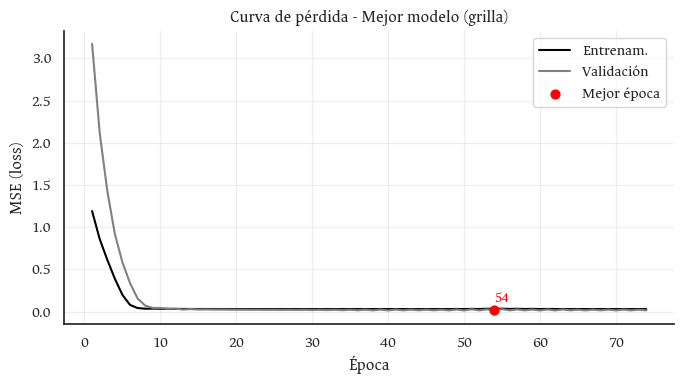

Figura guardada en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml/cnn_loss_best_grid.png


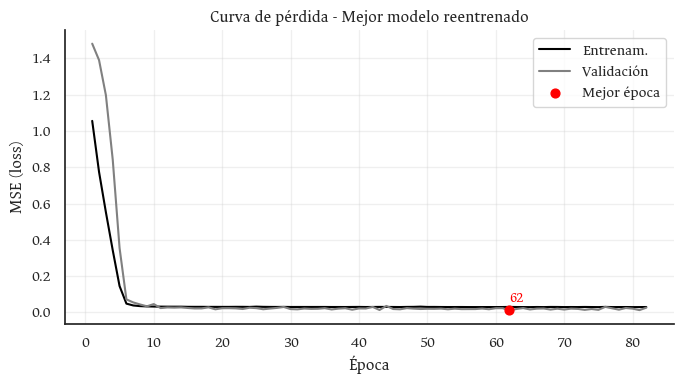

Figura guardada en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml/cnn_loss_best_retrain.png


In [28]:
# Curvas de pérdida (train/val) del modelo base y mejor modelo
import numpy as np
import matplotlib.pyplot as plt
from viz.style import get_palette

pal = get_palette(5)


def plot_loss_curves(history_obj, title, out_file):
    if hasattr(history_obj, 'history'):
        h = history_obj.history
    elif isinstance(history_obj, dict):
        h = history_obj
    else:
        print(f"No se puede graficar '{title}': formato de history no reconocido")
        return
    loss = h.get('loss', [])
    val_loss = h.get('val_loss', [])
    if len(loss) == 0 and len(val_loss) == 0:
        print(f"'{title}': no hay claves 'loss'/'val_loss' disponibles")
        return
    epochs = np.arange(1, max(len(loss), len(val_loss)) + 1)

    # Usar API orientada a ejes
    fig, ax = plt.subplots(figsize=(7,4))

    # Estilos solicitados
    if len(loss):
        ax.plot(epochs[:len(loss)], loss, label='Entrenam.', color='black', linestyle='-')
    if len(val_loss):
        ax.plot(epochs[:len(val_loss)], val_loss, label='Validación', color='gray', linestyle='-')
        try:
            best_ep = int(np.argmin(val_loss)) + 1
            best_val = val_loss[best_ep - 1]
            # Punto rojo en el mínimo de validación y etiqueta con número de época
            ax.scatter(best_ep, best_val, color='red', s=40, zorder=3, label='Mejor época')
            # Calcular pequeño desplazamiento vertical para ubicar el número más arriba
            y_min, y_max = ax.get_ylim()
            y_offset = 0.02 * (y_max - y_min)
            ax.text(best_ep, best_val + y_offset, f'{best_ep}', color='red', fontsize=10, ha='left', va='bottom')
            # Línea vertical del mínimo (opcional, comentada por solicitud)
            # ax.axvline(best_ep, color='#888888', ls='--', lw=1, label=f'Mín val @ {best_ep}')
        except Exception:
            pass

    # Solo marcos inferior e izquierdo
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_title(title)
    ax.set_xlabel('Época')
    ax.set_ylabel('MSE (loss)')
    ax.grid(alpha=0.3)
    ax.legend()

    plt.tight_layout()
    save_path = os.path.join(OUT_DIR, out_file)
    fig.savefig(save_path, dpi=180)
    plt.show()
    print('Figura guardada en:', save_path)

# 1) Modelo base (si existe `hist`)
if 'hist' in globals():
    plot_loss_curves(hist, 'Curva de pérdida - Modelo base', 'cnn_loss_base.png')
else:
    print('Historial del modelo base no disponible (variable `hist`).')

# 2) Mejor modelo (historia de la mejor combinación durante grilla)
if 'best' in globals() and isinstance(best.get('history'), dict):
    plot_loss_curves(best['history'], 'Curva de pérdida - Mejor modelo (grilla)', 'cnn_loss_best_grid.png')
else:
    print('Historial del mejor modelo de grilla no disponible en `best["history"]`.')

# 3) Mejor modelo reentrenado (si se volvió a entrenar guardando `hist_best`)
if 'hist_best' in globals():
    plot_loss_curves(hist_best, 'Curva de pérdida - Mejor modelo reentrenado', 'cnn_loss_best_retrain.png')


Exact explainer: 301it [04:45,  1.01it/s]                         

Importancias SHAP por paso guardadas en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml/shap_importance_by_time.csv


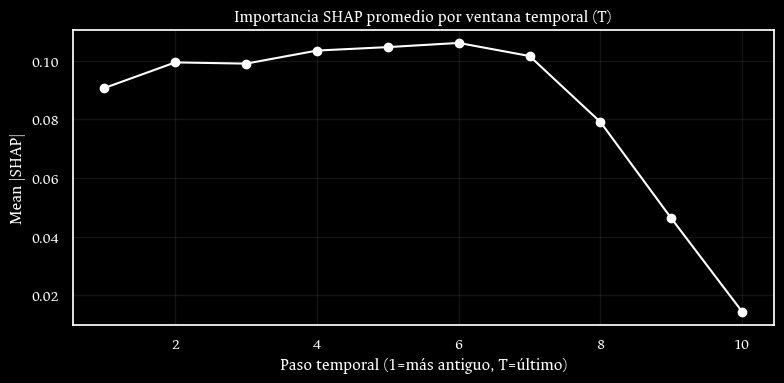

Figura guardada en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml/shap_mean_abs_by_time.png


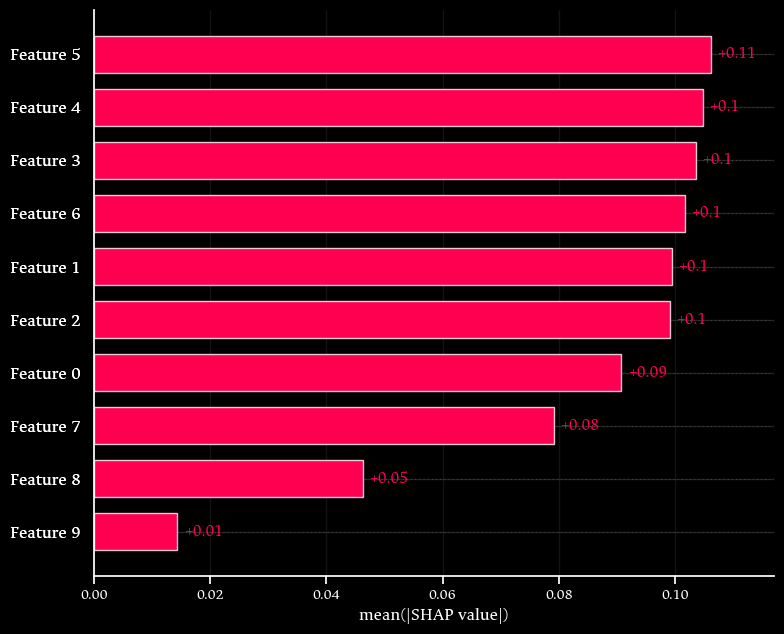

Figura guardada en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml/shap_summary_bar.png


In [ ]:
# Explicabilidad: valores SHAP sobre X_train (mejor modelo) usando Kernel Explainer
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

# Compatibilidad numpy/shap
if not hasattr(np, 'bool'):
    np.bool = np.bool_
if not hasattr(np, 'int'):
    np.int = int

# Requisitos previos
assert 'best_model' in globals(), 'No existe best_model. Ejecuta la celda de reentrenamiento del mejor modelo.'
assert 'X_train' in globals() and X_train.ndim == 3, 'Se espera X_train con forma (N,T,1)'

# Preparar subconjuntos
rng = np.random.default_rng(42)
idx_bg = rng.choice(X_train.shape[0], size=min(100, X_train.shape[0]), replace=False)
background = X_train[idx_bg]
idx_explain = rng.choice(X_train.shape[0], size=min(300, X_train.shape[0]), replace=False)
X_explain = X_train[idx_explain]

# Flatten temporal para un explainer tabular (Kernel)
# (N, T, 1) -> (N, T)
background_flat = background.squeeze(-1)
X_explain_flat = X_explain.squeeze(-1)

# Definir masker independiente por feature temporal
masker = shap.maskers.Independent(data=background_flat)

# Wrapper para rehacer dimensión (T,1) en predict
def _predict_flat(x_flat):
    x3 = np.array(x_flat, dtype='float32').reshape((-1, X_train.shape[1], 1))
    return best_model.predict(x3, verbose=0).reshape(-1)

explainer = shap.Explainer(_predict_flat, masker)
shap_values = explainer(X_explain_flat)

# Importancias promedio por paso temporal
mean_abs_by_t = np.abs(shap_values.values).mean(axis=0)  # (T,)

# Guardar CSV
time_steps = np.arange(1, X_train.shape[1]+1)
csv_path = os.path.join(OUT_DIR, 'shap_importance_by_time.csv')
pd.DataFrame({'time_step': time_steps, 'mean_abs_shap': mean_abs_by_t}).to_csv(csv_path, index=False)
print('Importancias SHAP por paso guardadas en:', csv_path)



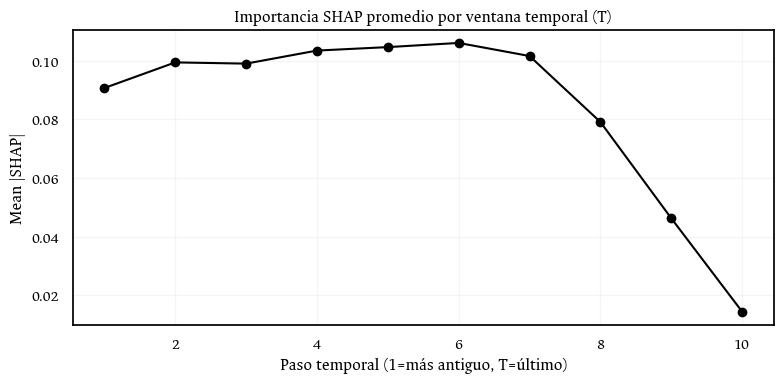

Figura guardada en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml/shap_mean_abs_by_time.png


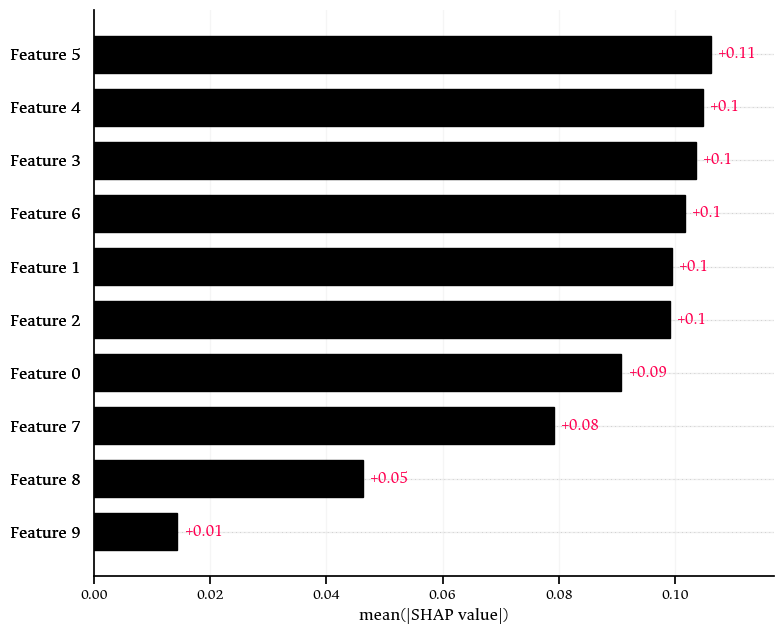

Figura guardada en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml/shap_summary_bar.png


In [30]:
# Gráfico línea (fondo blanco, elementos negros)
fig, ax = plt.subplots(figsize=(8,4))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.plot(time_steps, mean_abs_by_t, marker='o', color='black', markerfacecolor='black', markeredgecolor='black')
ax.set_title('Importancia SHAP promedio por ventana temporal (T)', color='black')
ax.set_xlabel('Paso temporal (1=más antiguo, T=último)', color='black')
ax.set_ylabel('Mean |SHAP|', color='black')
ax.grid(alpha=0.3, color='#e0e0e0')
for spine in ax.spines.values():
    spine.set_color('black')
ax.tick_params(colors='black')
plot_path = os.path.join(OUT_DIR, 'shap_mean_abs_by_time.png')
plt.tight_layout(); fig.savefig(plot_path, dpi=180, facecolor=fig.get_facecolor()); plt.show()
print('Figura guardada en:', plot_path)

# Bar summary (fondo blanco; barras y elementos en negro)
shap.plots.bar(shap_values, show=False)
fig_b = plt.gcf()
ax_b = plt.gca()
fig_b.patch.set_facecolor('white')
ax_b.set_facecolor('white')
for spine in ax_b.spines.values():
    spine.set_color('black')
ax_b.tick_params(colors='black')
if ax_b.title: ax_b.title.set_color('black')
if ax_b.xaxis.label: ax_b.xaxis.label.set_color('black')
if ax_b.yaxis.label: ax_b.yaxis.label.set_color('black')
ax_b.grid(alpha=0.3, color='#e0e0e0')
# Convertir todas las barras a negro
for p in ax_b.patches:
    try:
        p.set_facecolor('black')
        p.set_edgecolor('black')
    except Exception:
        pass
bar_path = os.path.join(OUT_DIR, 'shap_summary_bar.png')
plt.tight_layout(); fig_b.savefig(bar_path, dpi=180, facecolor=fig_b.get_facecolor()); plt.show()
print('Figura guardada en:', bar_path)


Mapa índice → etiqueta:
 feature_index feature_label         nota
             0          t-10  más antiguo
             1           t-9             
             2           t-8             
             3           t-7             
             4           t-6             
             5           t-5             
             6           t-4             
             7           t-3             
             8           t-2             
             9           t-1 más reciente


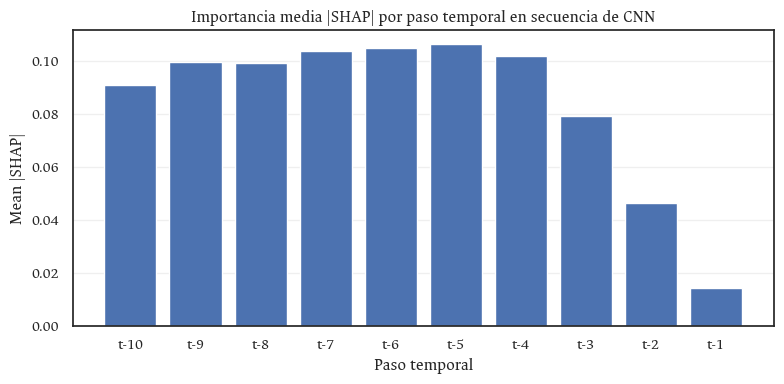

Figura guardada en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml/shap_summary_bar_named.png


In [20]:
# Etiquetas de features (ventana temporal) y gráfico con nombres
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# Construir etiquetas: índice 0 = t-T (más antiguo), índice T-1 = t-1 (más reciente)
T_local = int(X_train.shape[1])
labels = [f't-{T_local - i}' for i in range(T_local)]
notes = ['más antiguo'] + ['']*(max(T_local-2,0)) + (['más reciente'] if T_local>1 else [])

mapping_df = pd.DataFrame({
    'feature_index': np.arange(T_local),
    'feature_label': labels,
    'nota': notes
})
print('Mapa índice → etiqueta:')
print(mapping_df.to_string(index=False))

# Importancias para etiquetas
try:
    imp = mean_abs_by_t  # de la celda SHAP anterior
except NameError:
    # cargar de CSV si no está en memoria
    _csv = os.path.join(OUT_DIR, 'shap_importance_by_time.csv')
    imp = pd.read_csv(_csv)['mean_abs_shap'].values

# Gráfico de barras con etiquetas correctas
plt.figure(figsize=(8,4))
plt.bar(labels, imp)
plt.title('Importancia media |SHAP| por paso temporal en secuencia de CNN')
plt.xlabel('Paso temporal'); plt.ylabel('Mean |SHAP|')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
bar_named = os.path.join(OUT_DIR, 'shap_summary_bar_named.png')
plt.tight_layout(); plt.savefig(bar_named, dpi=180); plt.show()
print('Figura guardada en:', bar_named)
